In [34]:
## imports ##
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm, decomposition, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter("ignore")
np.random.seed(100)

## Contents:

- Gait data being used is based on the PDKit mPowerV1 data, collapsed by each healthCode ids
- Features chosen are based on a feature_engineering.ipnb
- For this ML Analysis, we will split the training-test set by 20%
- Parameters will be searched through grid search (GridSearchCV) and the score is assessed using Stratified 10-Fold Validation 
- Models being used: Logistic Regression, Xtreme Gradient Boost, Sklearn Gradient Boost and Random Forests
- Feature elimination will be done on several model using recursive feature elimination CV (Sklearn RFECV package)
- Learning Curves of each model (Work in progress)
- Best model will be dump into .pkl file (Work in progress)

## Helper Functions

In [66]:
def logreg_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state = 100))
        ])
    param = [{'classifier__penalty': ['l2'], 
              'classifier__solver': [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}, 
             {'classifier__penalty': ['l1'], 
              'classifier__solver': [ 'liblinear', 'saga']}  
            ]

    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV



def xgb_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ('kbest', SelectKBest(chi2)),
        ('classifier', XGBClassifier(seed = 100))
        ])
    param = {
        "kbest__k": [32]
#         "classifier__learning_rate" : [0.01, 0.05, 0.1],
#         "classifier__tree_method"   : ["hist", "auto"],
#         "classifier__max_depth"     : [6, 8],
#         "classifier__gamma"         : [0, 1],
#         "classifier__subsample"     : [0.8],
#         "classifier__n_estimators"  : [100]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV
    

def gradientboost_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ('kbest', SelectKBest(chi2)),
        ('classifier', GradientBoostingClassifier(random_state = 100, warm_start = True))
        ])
    param = {
        "kbest__k": [32]
#         'classifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
#         'classifier__max_depth':[1, 2, 3, 4, 5, 6],
#         'classifier__loss': ["deviance", "exponential"], ## exponential will result in adaBoost
#         "classifier__n_estimators"  : [100]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV

def randomforest_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ('kbest', SelectKBest(chi2)),
        ('classifier', RandomForestClassifier(random_state = 100))
        ])
    param = {
        "kbest__k": [32]
#         'classifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#         'classifier__criterion': ["gini", "entropy"],## exponential will result in adaBoost
#         'classifier__max_features': ["auto", "sqrt", "log2", None], 
#         'classifier__n_estimators'  : [100, 200]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV


def printPerformance(model, X_test, y_test):
    print("Mean AUC score on K-folds: {}".format(model.best_score_))
    print("Parameter Used: {}".format(model.best_params_))
    y_true, y_pred = y_test, model.predict(X_test)
    print("ROC-AUC on Test-Set: {}".format(metrics.roc_auc_score(y_true, y_pred)))
    print("log-loss: {}".format(metrics.log_loss(y_true, y_pred)))
    print("Precision: {}".format(metrics.precision_score(y_true, y_pred)))
    print("Recall: {}".format(metrics.recall_score(y_true, y_pred)))
    print("F1-Score: {}".format(metrics.f1_score(y_true, y_pred)))

## Split to Training and Testing Sets

In [67]:
walking_train = pd.read_csv("../Data/walking_data_training.csv", index_col=0)
walking_train_imputed = pd.read_csv("../Data/walking_imputed.csv", index_col=0)
walking_test_imputed = pd.read_csv("../Data/walking_imputed_test_data.csv", index_col=0)
balance_train = pd.read_csv("../Data/balance_data_training.csv", index_col=0).dropna()
balance_X_train, balance_X_test, balance_y_train, balance_y_test = train_test_split(balance_train.drop(["healthCode", "PD"], axis = 1), balance_train["PD"], test_size=0.20, random_state = 100)
walking_X_train, walking_X_test, walking_y_train, walking_y_test = train_test_split(walking_train.drop(["healthCode", "PD"], axis = 1), walking_train["PD"], test_size=0.20, random_state = 100)

## Run Model on Walking Data

In [68]:
lr_walking_model = logreg_fit(walking_X_train, walking_y_train)
rf_walking_model = randomforest_fit(walking_X_train, walking_y_train)
gb_walking_model = gradientboost_fit(walking_X_train, walking_y_train)
xgb_walking_model = xgb_fit(walking_X_train, walking_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_walking_model, walking_X_test.dropna(), walking_y_test.dropna())
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_walking_model, walking_X_test.dropna(), walking_y_test.dropna())
print("\n### Random Forest Walking ###")
printPerformance(rf_walking_model, walking_X_test.dropna(), walking_y_test.dropna())
print("\n### Logistic Regression Walking ###")
printPerformance(lr_walking_model, walking_X_test.dropna(), walking_y_test.dropna())


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.5787815126050421
Parameter Used: {'kbest__k': 32}
ROC-AUC on Test-Set: 0.6865079365079365
log-loss: 10.627418326309723
Precision: 0.6875
Recall: 0.6111111111111112
F1-Score: 0.6470588235294118

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.592203548085901
Parameter Used: {'kbest__k': 32}
ROC-AUC on Test-Set: 0.6587301587301587
log-loss: 11.513027977461276
Precision: 0.6666666666666666
Recall: 0.5555555555555556
F1-Score: 0.606060606060606

### Random Forest Walking ###
Mean AUC score on K-folds: 0.6088935574229692
Parameter Used: {'kbest__k': 32}
ROC-AUC on Test-Set: 0.5595238095238095
log-loss: 15.055528089562134
Precision: 0.5294117647058824
Recall: 0.5
F1-Score: 0.5142857142857143

### Logistic Regression Walking ###
Mean AUC score on K-folds: 0.5217086834733894
Parameter Used: {'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
ROC-AUC on Test-Set: 0.5873015873015873
log-loss: 14.1699184

In [51]:
xgb_walking_model.best_estimator_

Pipeline(memory=None,
         steps=[('kbest',
                 SelectKBest(k=16,
                             score_func=<function chi2 at 0x00000256F3CFE840>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=100, silent=None, subsample=0.8,
                               tree_method='auto', verbosity=1))],
         verbose=False)

## Recursive Feature Elimination 

In [27]:
selector = RFECV(gb_walking_model.best_estimator_[0], verbose = 3,  step=1, cv=10)

In [28]:
selector.fit(walking_X_train, walking_y_train)

Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 feature

RFECV(cv=10,
      estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                           learning_rate=0.05, loss='deviance',
                                           max_depth=1, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='auto', random_state=100,
                                           subsample=1.0, tol=0.0001,
                                           validation_fraction=0.1, verbose=

In [30]:
print(metrics.classification_report(selector.predict(walking_X_test), 
                                    walking_y_test))


print(metrics.roc_auc_score(selector.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        24
           1       0.61      0.73      0.67        15

    accuracy                           0.72        39
   macro avg       0.71      0.72      0.71        39
weighted avg       0.73      0.72      0.72        39

0.7208333333333332


## Confusion Matrix 

In [33]:
print(metrics.classification_report(gb_walking_model.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81        26
           1       0.61      0.85      0.71        13

    accuracy                           0.77        39
   macro avg       0.76      0.79      0.76        39
weighted avg       0.81      0.77      0.78        39



In [7]:
pd.crosstab(rf_walking_model.best_estimator_[0].predict(walking_X_test), 
            walking_y_test, 
            rownames = ["Actual"], 
            colnames = ["Predicted"])

Predicted,0,1
Actual,,
0,18,8
1,3,10


In [8]:
## Model Feature Importances by Gini Index
pd.Series(data = rf_walking_model.best_estimator_[0].feature_importances_, 
          index = walking_X_test.columns).nlargest(10)

max_gait_symmetry userAccel_walking_features_z           0.066313
max_count_freeze_index userAccel_walking_features_AA     0.053694
max_median_freeze_index userAccel_walking_features_y     0.050341
max_median_freeze_index userAccel_walking_features_AA    0.045981
max_median_freeze_index userAccel_walking_features_x     0.044942
max_no_of_steps userAccel_walking_features_z             0.044301
max_gait_symmetry userAccel_walking_features_x           0.042565
max_frequency_of_peaks userAccel_walking_features_z      0.041192
max_count_freeze_index userAccel_walking_features_z      0.039338
max_no_of_steps userAccel_walking_features_x             0.037557
dtype: float64

In [9]:
## Model Feature Importances
pd.Series(data = xgb_walking_model.best_estimator_[0].feature_importances_, 
          index = walking_X_test.columns).nlargest(10)

max_gait_symmetry userAccel_walking_features_z          0.060007
max_count_freeze_index userAccel_walking_features_AA    0.056987
max_count_freeze_index userAccel_walking_features_x     0.049644
max_count_freeze_index userAccel_walking_features_z     0.045705
max_no_of_steps userAccel_walking_features_z            0.044246
max_median_freeze_index userAccel_walking_features_x    0.043847
max_gait_symmetry userAccel_walking_features_x          0.042885
max_median_freeze_index userAccel_walking_features_y    0.040835
max_frequency_of_peaks userAccel_walking_features_x     0.037759
max_speed_of_gait userAccel_walking_features_AA         0.037445
dtype: float32

# Learning Curves

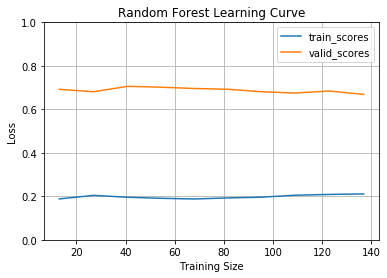

In [10]:
train_sizes, train_scores, valid_scores = learning_curve(rf_walking_model.best_estimator_[0], 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Random Forest Learning Curve")
plt.ylim(0,1)
plt.xlabel("Training Size")
plt.grid()

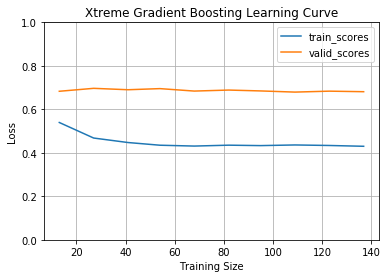

In [11]:
train_sizes, train_scores, valid_scores = learning_curve(xgb_walking_model.best_estimator_[0], 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Xtreme Gradient Boosting Learning Curve")
plt.ylim(0,1)
plt.xlabel("Training Size")
plt.grid()

In [32]:
train_sizes, train_scores, valid_scores = learning_curve(selector, 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Xtreme Gradient Boosting Learning Curve")
plt.ylim(0,1)
plt.xlabel("Training Size")
plt.grid()

ValueError: n_splits=10 cannot be greater than the number of members in each class.

# Balance Data

In [120]:
lr_balance_model = logreg_fit(balance_X_train, balance_y_train)
rf_balance_model = randomforest_fit(balance_X_train, balance_y_train)
gb_balance_model = gradientboost_fit(balance_X_train, balance_y_train)
xgb_balance_model = xgb_fit(balance_X_train, balance_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_balance_model, balance_X_test.dropna(), balance_y_test.dropna())
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_balance_model, balance_X_test.dropna(), balance_y_test.dropna())
print("\n### Random Forest Walking ###")
printPerformance(rf_balance_model, balance_X_test.dropna(), balance_y_test.dropna())
print("\n### Logistic Regression Walking ###")
printPerformance(lr_balance_model, balance_X_test.dropna(), balance_y_test.dropna())


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6044584500466854
Parameter Used: {'classifier__learning_rate': 0.1, 'classifier__loss': 'exponential', 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.5595238095238095
log-loss: 15.055528089562134
Precision: 0.5294117647058824
Recall: 0.5
F1-Score: 0.5142857142857143

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6718020541549954
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'hist'}
ROC-AUC on Test-Set: 0.5833333333333334
log-loss: 14.169897935912369
Precision: 0.5625
Recall: 0.5
F1-Score: 0.5294117647058824

### Random Forest Walking ###
Mean AUC score on K-folds: 0.685749299719888
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__n_estimato